### ACL-ATC Data Set
2 CLASSES
0-incidental
1-influential



### Preparation Steps

In [1]:
!pip install jsonlines
!pip install transformers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import jsonlines
import shutil

from string import punctuation
import string
import numpy as np

import os, os.path
import pandas as pd

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from os.path import join
from absl import flags
import os
import sys
import csv
import collections
import numpy as np
import time
import math
import json
import random
from copy import copy
from collections import defaultdict as dd

import absl.logging as _logging  # pylint: disable=unused-import
import tensorflow as tf

#import sentencepiece as spm

import argparse

import tensorflow as tf
import numpy as np

from transformers import pipeline

import json

In [2]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 14:52:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Edit the csv dataset to put the string labels instead of the numeric labels.
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'train.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [5]:
# Create a mapping dictionary for integer to string labels
label_mapping = {0: 'incidental', 1: 'influencial'}

# Use the mapping dictionary and the apply function to create the new 'label' column
df_train['string_label'] = df_train['citation_influence_label'].apply(lambda x: label_mapping.get(x, 'Unknown'))

# Display the updated DataFrame
print(df_train)

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

---

### Make inference with the **"model="facebook/bart-large-mnli"**

###  Set the function that implements a Zero-Shot-Classification Pipeline.

In [6]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df



### Make Inference

In [7]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [8]:
# Store the predictions' results to a csv file.
predictions_atl2.to_csv('inferred_classes_atl2_fb.csv', index=False)

### Set the function that calculates all evaluation metrics for the model's infered results.

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    # class_labels should be a list of strings representing your class labels

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision (Micro/Macro/Weighted): {precision_micro:.4f} / {precision_macro:.4f} / {precision_weighted:.4f}')

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall (Micro/Macro/Weighted): {recall_micro:.4f} / {recall_macro:.4f} / {recall_weighted:.4f}')

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Micro/Macro/Weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_weighted:.4f}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a DataFrame for better visualization with class labels
    conf_mat_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Measure the performance of inferred data on the dataset.

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

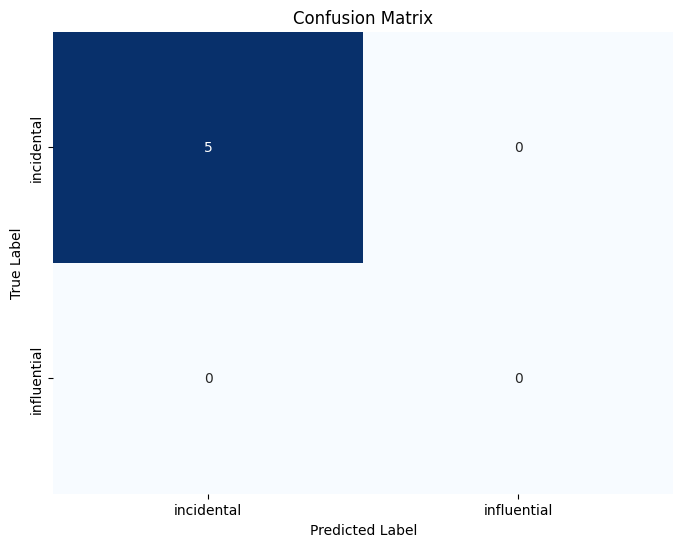

In [10]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = 'inferred_classes_atl2_fb.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [11]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1563
influencialinfluencial    1425
influencialincidental        7
incidentalincidental         5
Name: check, dtype: int64


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.4167, Recall=0.0032, F1-Score=0.0063
Class 1 (influential): Precision=0.4769, Recall=0.9951, F1-Score=0.6448


---
---

### Make inference with the **model = MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli**

In [6]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df



In [7]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [9]:
predictions_atl2.to_csv('inferred_classes_atl2_deberta.csv', index=False)

### Set the inference results' evaluation function.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_multiclass_classification(y_true, y_pred, class_labels):
   

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision (Micro/Macro/Weighted): {precision_micro:.4f} / {precision_macro:.4f} / {precision_weighted:.4f}')

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall (Micro/Macro/Weighted): {recall_micro:.4f} / {recall_macro:.4f} / {recall_weighted:.4f}')

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Micro/Macro/Weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_weighted:.4f}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a DataFrame for better visualization with class labels
    conf_mat_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Evaluate the predictions' results.

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

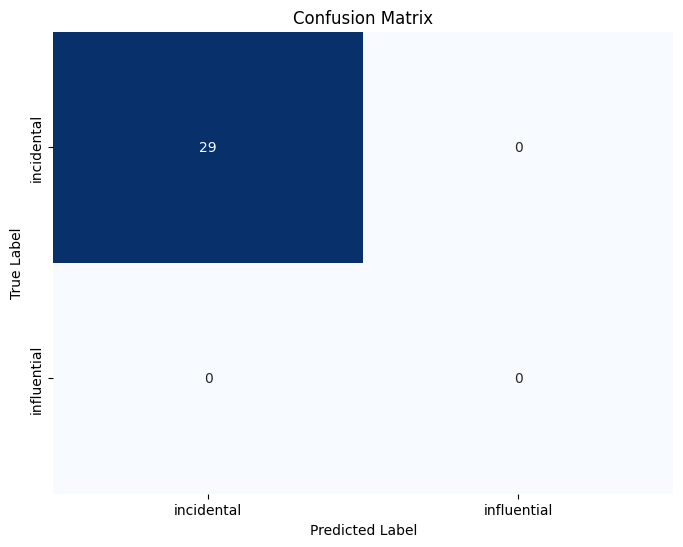

In [11]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl2_deberta.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [12]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1539
influencialinfluencial    1406
incidentalincidental        29
influencialincidental       26
Name: check, dtype: int64


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.5273, Recall=0.0185, F1-Score=0.0357
Class 1 (influential): Precision=0.4774, Recall=0.9818, F1-Score=0.6424


---
---

### Make predictions with the ** model = knowledgator/comprehend_it-base**

### Set the function with the inference pipeline.

In [14]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="knowledgator/comprehend_it-base", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make predictions.

In [15]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [16]:
predictions_atl2.to_csv('inferred_classes_atl2_know.csv', index=False)

### Evaluate predictions results.

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

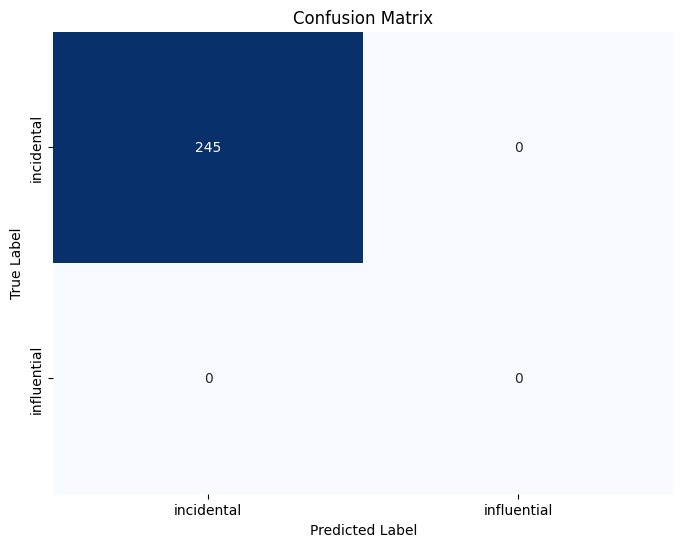

In [17]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl2_know.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [18]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1323
influencialinfluencial    1211
incidentalincidental       245
influencialincidental      221
Name: check, dtype: int64


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.5258, Recall=0.1562, F1-Score=0.2409
Class 1 (influential): Precision=0.4779, Recall=0.8457, F1-Score=0.6107


---
---

### Make precictions with the **model = MoritzLaurer/mDeBERTa-v3-base-mnli-xnli**

### Set the inference pipeline

In [20]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make predictions

In [21]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [22]:
predictions_atl2.to_csv('inferred_classes_atl2_mdeberta.csv', index=False)

### Evaluate Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

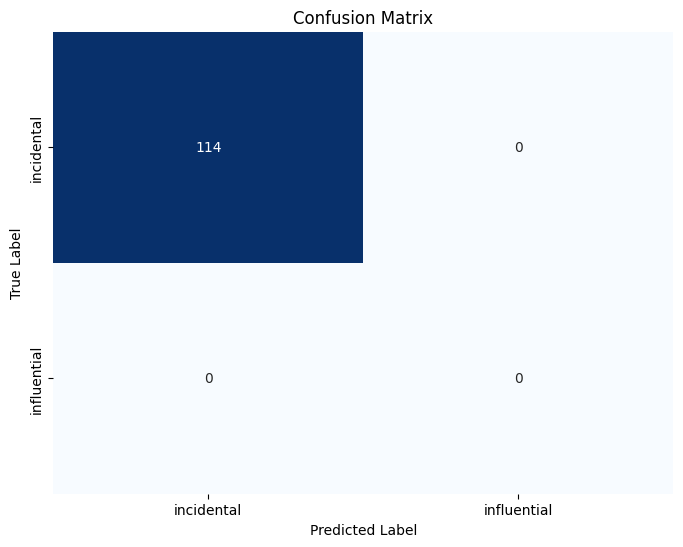

In [23]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl2_mdeberta.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [24]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1454
influencialinfluencial    1338
incidentalincidental       114
influencialincidental       94
Name: check, dtype: int64


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.5481, Recall=0.0727, F1-Score=0.1284
Class 1 (influential): Precision=0.4792, Recall=0.9344, F1-Score=0.6335


---
---

### Make predictions with the **model = MoritzLaurer/DeBERTa-v3-base-mnli**

### Set the inference pipeline.

In [28]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="cross-encoder/nli-distilroberta-base", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make Predictions

In [29]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [30]:
predictions_atl2.to_csv('inferred_classes_atl2_distil.csv', index=False)

### Evaluate Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

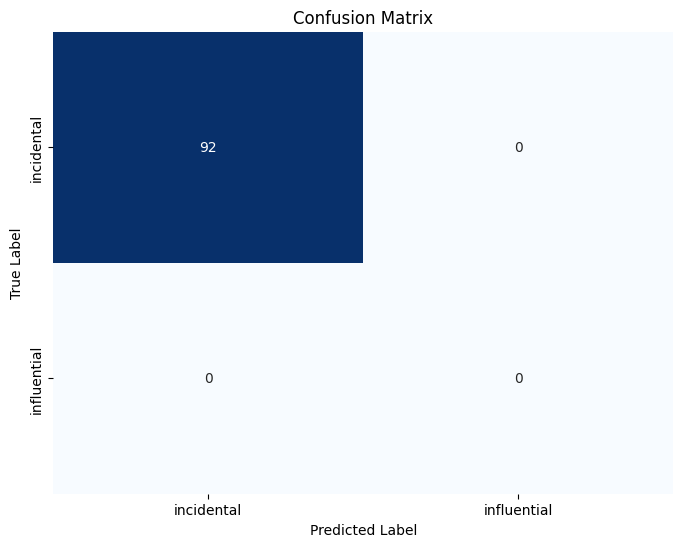

In [31]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl2_distil.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [32]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1476
influencialinfluencial    1343
incidentalincidental        92
influencialincidental       89
Name: check, dtype: int64


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.5083, Recall=0.0587, F1-Score=0.1052
Class 1 (influential): Precision=0.4764, Recall=0.9378, F1-Score=0.6319


---
---

### Make predictions with the **model = roberta-large-mnli**

### Set the inference pipeline

In [34]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="typeform/roberta-large-mnli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["incidental", "influencial"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make Predictions

In [35]:
predictions_atl2 = zero_shot(df_train)
print (predictions_atl2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at typeform/roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [36]:
predictions_atl2.to_csv('inferred_classes_atl2_robertalarge.csv', index=False)

### Evaluate Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

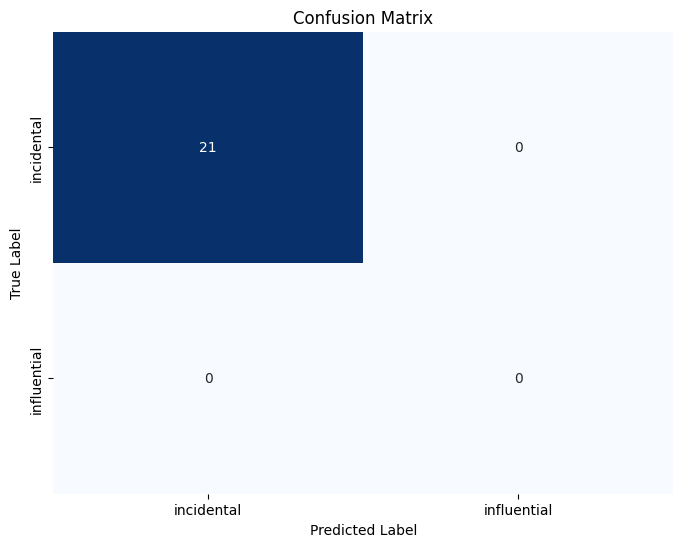

In [38]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl2_robertalarge.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["string_label"], df_train["inferred_label"], ["incidental", "influential"])

In [39]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["string_label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

incidentalinfluencial     1547
influencialinfluencial    1413
incidentalincidental        21
influencialincidental       19
Name: check, dtype: int64


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["string_label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["string_label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["string_label"], df_train["inferred_label"], average=None)

class_labels = ["incidental", "influential"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (incidental): Precision=0.5250, Recall=0.0134, F1-Score=0.0261
Class 1 (influential): Precision=0.4774, Recall=0.9867, F1-Score=0.6434
